# DATA2001 S1 2021 Practical Assignment - Bushfire Risk Analysis (Notebook)
*An analysis of neighbourhood fire risk and median income & rent.*

**Assignment Group F14 - 3**

**Eugene Ward (SID: 311193781) & Matthew Shu (SID: )**

---

## Setup: Import libraries and create functions

In [ ]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np

import requests
import json

from shapely.geometry import Point, Polygon, MultiPolygon
from geopandas import GeoSeries, GeoDataFrame
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras

import matplotlib.pyplot as plt

# Function for accessing Postgres DB (SOURCE: DATA2001 Lab materials) - Eugene uses this
def pgconnect_using_credfile(credential_filepath):
    try:
        with open(credential_filepath) as f:
            db_conn_dict = json.load(f)
        connstring = 'postgres+psycopg2://'+db_conn_dict['user']+':'+db_conn_dict['password']+'@'+db_conn_dict['host']+'/'+db_conn_dict['database']
        db = create_engine(connstring, echo=False)
        conn = db.connect()
        print('connected')
    except Exception as e:
        print("unable to connect to the database")
        print(e)
        return None
    return db,conn

# Function for querying the PostgreSQL DB.
# Returns value and a converted dataframe (SOURCE: DATA2001 Lab materials)
def pgquery( conn, sqlcmd, args=None, silent=False ):
    """ utility function to execute some SQL query statement
    can take optional arguments to fill in (dictionary)
    will print out on screen the result set of the query
    error and transaction handling built-in """
    retdf = pd.DataFrame()
    retval = False
    try:
        if args is None:
            retdf = pd.read_sql_query(sqlcmd,conn)
        else:
            retdf = pd.read_sql_query(sqlcmd,conn,params=args)
        if silent == False:
            print(retdf.shape)
            print(retdf.to_string())
        retval = True
    except Exception as e:
        if silent == False:
            print("db read error: ")
            print(e)
    return retval,retdf

# WKT point geom creation function (SOURCE: DATA2001 Lab materials)
def create_wkt_point_element(geom,srid):
    return WKTElement(geom.wkt, srid)

# WKT polygon geom creation function (SOURCE: DATA2001 Lab materials)
# Adapted to handle conversion of empty geometries
def create_wkt_element(geom,srid):
    if (geom.geom_type == 'Polygon'):
        geom = MultiPolygon([geom])
    elif (geom.geom_type == 'GeometryCollection'):
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

# Z-score
def z(x, avg, sd):
    return((x-avg)/sd)

# Sigmoidal function. Did not use native exponential because fails for large negative values.
def sigmoid(x):
    return(1/(1+np.exp(-x)))

# Created and add z-score column for measure
def add_z_score_column(df, **kwargs):
    column = [c for c in df.columns.tolist() if 'density' in c][0] #Finds relevant column to calculate Z-score on
    if kwargs.get('column'):
        column = kwargs.get('column')
    mean = np.mean(df[column])
    std = np.std(df[column])
    df['z_score'] = df[column].map(lambda x: z(x, mean, std))
    return df

# Fire risk score formula
def fire_risk(pop_d, dwell_d, bus_d, bfpl_d, ass_serv_d, exchange_d):
    fire_risk_score = sigmoid(z(pop_d)+z(dwell_d)+z(bus_d)+z(bfpl_d)-z(ass_serv_d)-z(exchange_d))
    return fire_risk_score

print("Setup successful. Libraries imported and functions ready.")

In [ ]:
# ------ Internal use MATTHEW
#For troubleshooting in the case your data isn't loading.
#os.chdir('M:\\Jupyter Notebooks\\data2001_project')
#os.getcwd()

## Task 1: Data Integration and Database Generation

The 3 provided CSV files and 2 provided shapfiles are loaded in as dataframes/geodataframes, inspected and cleaned. We are also making use of one additional dataset, retrieved from a Geoscience Australia Web Service and converted to a geodataframe.

### Loading datasets (standard dataframes)

#### *Statistical Areas*

In [ ]:
stat_areas_df = pd.read_csv('./data/StatisticalAreas.csv')
print(stat_areas_df.dtypes)

In [ ]:
# Cleaning - remove duplicates
print(len(stat_areas_df.area_id.unique()))

# DUPLICATE ROWS in statisticalareas - confirmed
#print(stat_areas_df.area_id.value_counts())
#stat_areas_df.loc[stat_areas_df['area_id']==106]
#stat_areas_df.loc[stat_areas_df['area_id']==111]
#stat_areas_df.loc[stat_areas_df['area_id']==114]

print(len(stat_areas_df))
stat_areas_df = stat_areas_df.drop_duplicates()
print(len(stat_areas_df))

stat_areas_df.head(2)

#### *Neighbourhoods*

In [ ]:
nbhd_df = pd.read_csv('./data/Neighbourhoods.csv')

#nbhd_df.area_id.value_counts() # confirmed no duplicate area_id

# Changing column names according to assignment sheet
nbhd_df = nbhd_df.rename(columns={'number_of_dwellings':'dwellings', 'number_of_businesses':'businesses', 'median_annual_household_income':'median_income'}) 
nbhd_df.head(1)

In [ ]:
print(len(nbhd_df))
print(nbhd_df.dtypes)

In [ ]:
# Cleaning - correcting number representations
nbhd_df['population'] = nbhd_df['population'].str.replace(',','')
nbhd_df['population'] = nbhd_df['population'].astype('float64')

nbhd_df['dwellings'] = nbhd_df['dwellings'].str.replace(',','')
nbhd_df['dwellings'] = nbhd_df['dwellings'].astype('float64')

In [ ]:
# Note: NaN values present in neighbourhoods
# Decision - interpet NaN as 0
print(len(nbhd_df[nbhd_df.isna().any(axis=1)]))
nbhd_df[nbhd_df.isna().any(axis=1)]

#### *Business Stats*

In [ ]:
busi_stat_df = pd.read_csv('./data/BusinessStats.csv')

busi_stat_df = busi_stat_df.drop(columns=['area_name']) #Not in the required columns according to May revision of assigment sheet v3
busi_stat_df = busi_stat_df.rename(columns={'accommodation_and_food_services':'accommodation_and_food'}) #Changing column names according to assignment sheet

#busi_stat_df.area_id.value_counts() # confirmed no duplicates
print(len(busi_stat_df))
print(busi_stat_df.dtypes)

In [ ]:
# DECISION: cast area_id in each df as string in order to ensure integrity going into DB as non-numeric values
stat_areas_df['area_id'] = stat_areas_df['area_id'].astype('str')
print(stat_areas_df['area_id'].dtype)

nbhd_df['area_id'] = nbhd_df['area_id'].astype('str')
print(nbhd_df['area_id'].dtype)

busi_stat_df['area_id'] = busi_stat_df['area_id'].astype('str')
print(busi_stat_df['area_id'].dtype)

In [ ]:
# DESIGN DECISION: LIMIT BUSINESS STAT OBSERVATIONS IN DB TO THE NEIGHBOURHOODS STUDIED

print(len(busi_stat_df))
busi_stat_df = busi_stat_df.loc[busi_stat_df['area_id'].isin(nbhd_df['area_id'].tolist())]
print(len(busi_stat_df))

In [ ]:
# Note: No NAN values present in businessstats
busi_stat_df[busi_stat_df.isna().any(axis=1)]

### Loading datasets (geodataframes)
#### RFS NSW Bushfire Prone Land - shapefile

In [ ]:
rfs_gdf = gpd.read_file('./data/RFSNSW_BFPL/RFSNSW_BFPL.shp')
print(rfs_gdf.crs) # Check EPSG / CRS -- 4283 = GDA94
rfs_gdf.columns = [x.lower() for x in rfs_gdf.columns] # lower case col names
print(rfs_gdf.dtypes)
rfs_gdf.head(1)

In [ ]:
# Check geometries
print(len(rfs_gdf))
rfs_gdf.geometry.type.value_counts()

In [ ]:
# Recreate incrementing 'gid' (0 index)
rfs_gdf.insert(loc=0, column='gid', value=rfs_gdf.index)
rfs_gdf.head()

#### ABS Statistical Area 2 (2016) - shapefile

In [ ]:
sa2_gdf = gpd.read_file('./data/1270055001_sa2_2016_aust_shape/SA2_2016_AUST.shp')

print(sa2_gdf.crs) # Check EPSG / CRS -- 4283 = GDA94

sa2_gdf.columns = [x.lower() for x in sa2_gdf.columns] # lower case col names

# Recreate incrementing 'g_id' (0 index)
sa2_gdf.insert(loc=0, column='g_id', value=sa2_gdf.index)

# Changing column names according to assignment sheet
sa2_gdf=sa2_gdf.rename(columns={'sa3_code16':'sa3_code', 'sa3_name16':'sa3_name', 'sa4_code16':'sa4_code', 'sa4_name16':'sa4_name', 'gcc_code16':'gcc_code', 'gcc_name16':'gcc_name', 'ste_code16':'ste_code', 'ste_name16':'ste_name'})

sa2_gdf['sa2_main16'] = sa2_gdf['sa2_main16'].astype('str')

sa2_gdf.head(1)

In [ ]:
# Check geometries
print(len(sa2_gdf))
print(sa2_gdf.geometry.type.value_counts())
no_geoms_sa2 = sum(sa2_gdf.geometry.type.isna())
print(f'Null geometry count: {no_geoms_sa2}')

In [ ]:
# Inspection / preliminary exploration
print(sa2_gdf.ste_name.value_counts()) # Confirm federal level dataset
print("\n")
print(sa2_gdf.loc[sa2_gdf.ste_name=="New South Wales"]['gcc_name'].value_counts()) # Confirm Greater Sydney GCCSA

# Process to support report writing - confirm GS vs RONSW split of provided neighbourhoods
nbhd_join_sa2 = pd.merge(nbhd_df, sa2_gdf, left_on='area_id', right_on='sa2_main16')
print('\n')
print(nbhd_join_sa2.gcc_name.value_counts()) # 312 GS and 10 RONSW
print("\nThe assignment involves devising risk scores for all 312 Greater Sydney SA2s\nand the following 10 other NSW SA2s:\n")
nbhd_join_sa2.loc[nbhd_join_sa2.gcc_name == "Rest of NSW"]['area_name'].to_list()

In [ ]:
# DECISION: RETAIN THE 18 ROWS WHERE NO SPATIAL JOINS OR FUNCTIONS CAN BE PERFORMED (NULL GEOMETRIES)
# TO MAINTAIN FULL SA2 SHAPEFILE

### Additional dataset: Telephone Exchanges NSW
#### Geodataframe created from a retrieved JSON from ArcGIS REST Web Service provided by Geoscience Australia
Credentials are not required to run the request.

In [ ]:
# Geoscience Australia - National Telephone Exchanges ArcGIS REST Web Service (Open API - no key required)
# https://services.ga.gov.au/gis/rest/services/Telephone_Exchanges/MapServer/0
# Usage permitted under Creative Commons Attribution 4.0 International Licence

# This service requires a relational model style syntax for its parameters, 
# e.g. WHERE (STATE)='New South Wales'
# These params then need to be converted to URL encoded characters for making the endpoint GET request

# We query the active communications exchanges in New South Wales to form our additional dataset
# with parameter: format = json

query_param = "%28STATE%29%3D%27New+South+Wales%27" # (STATE)='New South Wales'
response = requests.get("https://services.ga.gov.au/gis/rest/services/Telephone_Exchanges/MapServer/0/query?where="+
                        query_param+
                        "&f=json")

assert response.status_code == 200

exchanges_json = response.json()

# We have inspected the full JSON result in previous requests and deploy the keys accordingly

print('EPSG:\n' + str(exchanges_json['spatialReference'])) # Confirmed GDA94

# Convert results to pandas dataframe
names_recs = []
longs = []
lats = []

for i in range(0, len(exchanges_json['features'])):
    item_name = exchanges_json['features'][i]['attributes']['name']
    item_long = exchanges_json['features'][i]['geometry']['x']
    item_lat = exchanges_json['features'][i]['geometry']['y']
    names_recs.append(item_name)
    longs.append(item_long)
    lats.append(item_lat)

names_series = pd.Series(names_recs)
longs_series = pd.Series(longs)
lats_series = pd.Series(lats)

exchanges_df = pd.DataFrame({'name': names_series, 'longitude': longs_series,
                            'latitude': lats_series})

# Convert the df to geodataframe where longitude and latitude are combined into POINT geometries
exchanges_gdf = gpd.GeoDataFrame(exchanges_df,
                                       geometry=gpd.points_from_xy(exchanges_df.longitude, exchanges_df.latitude))

exchanges_gdf = exchanges_gdf.drop(columns=['longitude', 'latitude'])
exchanges_gdf.plot(color='white', edgecolor='red')
exchanges_gdf.tail()

---

### Connecting with Database and Creation of Tables
#### *Running connection function with credentials*

#### **ATTN MARKER - DO *NOT* RUN** cell below

In [ ]:
### ---------------ATTN MARKER - DO *NOT* RUN---------------
# Alternative Function for accessing Postgres DB (SOURCE: DATA2001 Lab materials) - Matthew
# JUST FOR MATTHEW

def pgconnect_using_credfile(credential_filepath):
    try:
        args = {
            'sslmode':'disable',
            'gssencmode':'disable'
        }
        with open(credential_filepath) as f:
            db_conn_dict = json.load(f)
        connstring = 'postgresql+psycopg2://'+db_conn_dict['user']+':'+db_conn_dict['password']+'@'+db_conn_dict['host']+'/'+db_conn_dict['database']
        db = create_engine(connstring, echo=False, connect_args=args)
        conn = db.connect()
        print('connected')
    except Exception as e:
        print("unable to connect to the database")
        print(e)
        return None
    return db,conn

### CONNECT:

In [203]:
# Connect to University server student Postgres DB. 
# This function will not work if not on campus or if not connected to VPN.

credfilepath = './data2x01_db.json' # Internal note: not tracked on Git, must be locally available. 
# Eugene's credentials JSON to be uploaded in submission

db, conn = pgconnect_using_credfile(credfilepath)

connected


#### *Test connection and functions with PostGIS (Postgres geospatial plugin) check*

In [ ]:
# Checking we have PostGIS working on our connection (SOURCE: DATA2001 Lab materials)

postgis_check = '''
SELECT PostGIS_Version();
'''

retval,retdf = pgquery(conn,postgis_check)
retdf

### Creation of Database Tables (from dataframes)

In [ ]:
# Check existing tables in Postgres DB public schema
for table in db.table_names():
    print(f'{table}\n')

#### Considering set relationships between datasets for key designations

In [ ]:
# Establishing set relationships between tables
test_df = stat_areas_df.copy() # 431 unique area_ids exist in statisticalareas
subset = set(nbhd_df.area_id.unique()) # 322 unique area_ids exist in neighbourhoods
test_df['exists'] = stat_areas_df.area_id.map(lambda x : True if x in subset else False)
test_df['exists'].value_counts()

# Statisticalareas contains a set of area_ids of which the set of neighbourhoods area_id values is a subset 
# (It is a PK in its own table and an FK in relation to statisticalareas)

In [ ]:
# Note that there exists one more SA2 length ID in statisticalareas and that these 323 SA2s exist in the shapefile
sa2s_in_statareas = stat_areas_df.loc[stat_areas_df['area_id'].str.len() == 9]
sa2s_in_statareas.loc[~sa2s_in_statareas.area_id.isin(nbhd_df['area_id'].tolist())]

In [ ]:
# These 323 SA2s are a subset of the national SA2 shapefile attribute sa2_main16
# A foreign key relationship from area_id in both neighbourhoods and statisticalareas 
# to sa2_main16 would be appropriate IF sa2_main16 were a primary key however
# g_id has been designated PK; it is preferable that the 'area_id' meaning
# is preserved as definitive in the context where it can include other levels of statistical area (statisticalareas)

sa2s_in_statareas = stat_areas_df.loc[stat_areas_df['area_id'].str.len() == 9]
print(len(sa2s_in_statareas))

test_df2 = sa2_gdf.copy()
subset2 = set(sa2s_in_statareas.area_id.unique())
test_df2['exists'] = sa2_gdf.sa2_main16.map(lambda x : True if x in subset2 else False)
test_df2['exists'].value_counts()

# Finally, from a cleaning step which masked businessstats with neighbourhoods area_ids, 
# we know that businessstats will hold the same key relationships with statisticalareas as neighbourhoods

#### Statistical Areas

In [ ]:
conn.execute("DROP TABLE IF EXISTS statisticalareas")

stat_areas_create = '''CREATE TABLE statisticalareas (
                     area_id VARCHAR NOT NULL,
                     area_name VARCHAR NOT NULL,
                     parent_area_id VARCHAR NOT NULL,
                     CONSTRAINT statisticalareas_pkey PRIMARY KEY (area_id)
                     )'''

conn.execute(stat_areas_create)

In [ ]:
# Insert dataset
stat_areas_df.to_sql('statisticalareas', con = conn, if_exists = 'append', index=False)
print('Data inserted into Table')

# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM statisticalareas
LIMIT 1;""")
a_df.head()

#### Neighbourhoods

In [ ]:
conn.execute("DROP TABLE IF EXISTS neighbourhoods")

neighbourhoods_create = '''CREATE TABLE neighbourhoods (
                     area_id VARCHAR NOT NULL,
                     area_name VARCHAR NOT NULL,
                     land_area FLOAT NOT NULL,
                     population NUMERIC,
                     dwellings NUMERIC NOT NULL,
                     businesses NUMERIC,
                     median_income NUMERIC,
                     avg_monthly_rent NUMERIC,
                     CONSTRAINT neighbourhoods_pkey PRIMARY KEY (area_id),
                     CONSTRAINT neighbourhoods_fkey1 FOREIGN KEY(area_id) REFERENCES statisticalareas(area_id)
                     )'''

# ALLOW NULL for 'population' 'businesses' avg_monthly_rent' 'median_income'

conn.execute(neighbourhoods_create)

In [ ]:
# Insert dataset
nbhd_df.to_sql('neighbourhoods', con = conn, if_exists = 'append', index=False)
print('Data inserted into Table')

# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM neighbourhoods
LIMIT 1;""")
a_df.head()

#### Business Stats

In [ ]:
conn.execute("DROP TABLE IF EXISTS businessstats")

business_create = '''CREATE TABLE businessstats (
                     area_id VARCHAR NOT NULL,
                     number_of_businesses NUMERIC NOT NULL,
                     accommodation_and_food NUMERIC NOT NULL,
                     retail_trade NUMERIC NOT NULL,
                     agriculture_forestry_and_fishing NUMERIC NOT NULL,
                     health_care_and_social_assistance NUMERIC NOT NULL,
                     public_administration_and_safety NUMERIC NOT NULL,
                     transport_postal_and_warehousing NUMERIC NOT NULL,
                     CONSTRAINT businessstats_pkey PRIMARY KEY (area_id),
                     CONSTRAINT businessstats_fkey1 FOREIGN KEY(area_id) REFERENCES statisticalareas(area_id)
                     )'''

conn.execute(business_create)

In [ ]:
busi_stat_df.to_sql('businessstats', con = conn, if_exists = 'append', index=False)
print('Data inserted into Table')

# Check table
a_response, a_df = pgquery(conn, """SELECT COUNT(*) FROM businessstats
LIMIT 1;""")

In [ ]:
a_response, a_df = pgquery(conn, """SELECT * FROM businessstats
LIMIT 1;""")
a_df.head()

### Creation of Database Tables (from geodataframes)

#### RFS NSW Bushfire Prone Land - shapefile

In [ ]:
srid = 4283
rfs_gdf['geom'] = rfs_gdf['geometry'].apply(lambda x: create_wkt_point_element(geom=x, srid=srid))
rfs_gdf = rfs_gdf.drop(columns="geometry")
rfs_gdf.head()

In [ ]:
conn.execute("DROP TABLE IF EXISTS rfsnsw_bfpl")

rfs_bushfire_create = '''CREATE TABLE rfsnsw_bfpl (
                     gid INTEGER PRIMARY KEY,
                     category CHAR(1),
                     shape_leng FLOAT,
                     shape_area FLOAT,
                     geom GEOMETRY(POINT, 4283)
                     )'''

conn.execute(rfs_bushfire_create)

In [ ]:
srid = 4283
rfs_gdf.to_sql('rfsnsw_bfpl', conn, if_exists='append', index=False, 
                         dtype={'geom': Geometry('POINT', srid)})

In [ ]:
# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM rfsnsw_bfpl
LIMIT 1;""")
a_df.head()

#### ABS Statistical Area 2 (2016) - shapefile

In [ ]:
# FILL NONE GEOMETRIES WITH EMPTY GEOMETRY OBJECTS SO THAT THEY CAN BE PERSISTED
# See: https://geopandas.readthedocs.io/en/latest/docs/reference/api/geopandas.GeoSeries.fillna.html

sa2_gdf['geometry'] = sa2_gdf['geometry'].fillna()
print(len(sa2_gdf.loc[sa2_gdf.geometry.isna()]))
sa2_gdf.tail()

In [ ]:
srid = 4283

# WKT CONVERSION
sa2_gdf['geom'] = sa2_gdf['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid))
sa2_gdf = sa2_gdf.drop(columns="geometry")
sa2_gdf.tail()

In [ ]:
conn.execute("DROP TABLE IF EXISTS sa2_2016_aust")

sa2_shape_create = '''CREATE TABLE sa2_2016_aust (
                     g_id INTEGER PRIMARY KEY,
                     sa2_main16 VARCHAR,
                     sa2_5dig16 VARCHAR,
                     sa2_name16 VARCHAR,
                     sa3_code   VARCHAR,
                     sa3_name   VARCHAR,
                     sa4_code   VARCHAR,
                     sa4_name   VARCHAR,
                     gcc_code   VARCHAR,
                     gcc_name   VARCHAR,
                     ste_code   VARCHAR,
                     ste_name   VARCHAR,
                     areasqkm16 FLOAT,
                     geom GEOMETRY(MULTIPOLYGON, 4283)
                     )'''

conn.execute(sa2_shape_create)

In [ ]:
srid = 4283
sa2_gdf.to_sql('sa2_2016_aust', conn, if_exists='append', index=False, 
                         dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [ ]:
# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM sa2_2016_aust WHERE g_id = 2308""")

In [ ]:
pgquery(conn, """SELECT COUNT(*) FROM sa2_2016_aust
""")

### Creation of Database Table - Additional Dataset (geodataframe)

In [ ]:
# Use create_wkt_point_element function to create point geom column

srid = 4283
exchanges_gdf['geom'] = exchanges_gdf['geometry'].apply(lambda x: create_wkt_point_element(geom=x, srid=srid))
exchanges_gdf = exchanges_gdf.drop(columns="geometry")
exchanges_gdf.head()

In [ ]:
conn.execute("DROP TABLE IF EXISTS exchanges")

exchanges_create = '''CREATE TABLE exchanges (
                     name VARCHAR NOT NULL,
                     geom GEOMETRY(POINT, 4283),
                     CONSTRAINT exchanges_pkey PRIMARY KEY (name) 
                     )'''

conn.execute(exchanges_create)

In [ ]:
srid = 4283
exchanges_gdf.to_sql('exchanges', conn, if_exists='append', index=False,
                     dtype={'geom': Geometry('POINT', srid)})

In [ ]:
# Check table
a_response, a_df = pgquery(conn, """ SELECT * FROM exchanges WHERE name = 'Glebe' """)

## Task 2: Fire Risk Analysis

### Creation of helpful indexes

The Bushfire Prone Land dataset is very large but we cannot refine it beforehand - during computation of the measure we need to make spatial comparisons for all of its entries. The computation is intensive and slow so it is helpful to employ a spatial index by creating a GIST index on the rfsnsw_bfpl geom column.

In [ ]:
conn.execute("DROP INDEX IF EXISTS bfpl_geom_idx")

bf_index_create = '''CREATE INDEX bfpl_geom_idx
                          ON rfsnsw_bfpl
                      USING GIST (geom);'''

conn.execute(bf_index_create)

Since we are computing membership and relationships with the SA2 shapfiles, spatial queries involving sa2_2016_aust will benefit from this kind of index as well.

In [ ]:
conn.execute("DROP INDEX IF EXISTS sa2_geom_idx")

sa2_index_create = '''CREATE INDEX sa2_geom_idx
                          ON sa2_2016_aust
                      USING GIST (geom);'''

conn.execute(sa2_index_create)

Since the Exchanges spatial data is much smaller we deemed that index creation would not have much performance benefit.

### Computed Measures

#### Methodology note: area used in calculation of measures
For the following computed densities we use the sa2_2016_aust areasqkm16 column as that most accurately corresponds to area calculated based on geometry. The following query demonstrates our comparison process. 

There are data quality issues with the land_area column in neighbourhoods - note that some reflect a conversion from the sa2_2016_aust shapefile data to a smaller unit (e.g. Gosford-Springfield 16.9124 to 1691.2000) while others are the same (e.g. Goulburn Region at 9035.1221 in both). This is what prompted the manual check using ST_Area which affirmed the reliability of the sa2_2016_aust column. The difference in area in the pre-computed areasqkm16 vs the PostGIS result was not deemed significant enough to compute and store (or compute per query) area sizes so areasqkm16 is used in each measure calculation.

In [ ]:
query='''
SELECT n.area_name, n.land_area, sa.areasqkm16, ST_Area(sa.geom::geography)/1000000 AS total_area_km2 
FROM neighbourhoods AS n
INNER JOIN sa2_2016_aust AS sa
ON n.area_id=sa.sa2_main16
LIMIT 10;
'''
response, checking_df = pgquery(conn, query)
checking_df['difference_postgis_orig'] = checking_df['total_area_km2'] - checking_df['areasqkm16']
checking_df['difference_orig_postgis'] = checking_df['areasqkm16'] - checking_df['total_area_km2']
print(max(checking_df['difference_postgis_orig']))
print(max(checking_df['difference_orig_postgis']))

#### 1. Population Density

In [149]:
# As defined in methodology earlier, NaN value for population is interpreted as 0

query = '''
SELECT n.area_name, n.area_id, n.population, sa.areasqkm16, n.population/sa.areasqkm16 as population_density
FROM neighbourhoods AS n
INNER JOIN sa2_2016_aust AS sa
ON n.area_id=sa.sa2_main16
ORDER BY n.population/sa.areasqkm16 DESC;
'''
response, pop_df = pgquery(conn, query)

pop_df['population'] = pop_df['population'].fillna(0)
pop_df['population_density'] = pop_df['population_density'].fillna(0)

pop_df = add_z_score_column(pop_df)

(322, 5)
                                       area_name    area_id  population  areasqkm16  population_density
0                       Holsworthy Military Area  123021439         NaN    129.8230                 NaN
1                    Potts Point - Woolloomooloo  117031333     23809.0      1.4591        16317.593037
2                               Pyrmont - Ultimo  117031334     24083.0      1.4913        16148.997519
3                                   Darlinghurst  117031329     12414.0      0.8569        14487.104680
4                                    Surry Hills  117031336     18064.0      1.3164        13722.272865
5                          Redfern - Chippendale  117031335     25538.0      2.1631        11806.204059
6                        Waterloo - Beaconsfield  117031338     37929.0      3.5809        10592.029937
7                           Glebe - Forest Lodge  117031331     21592.0      2.3018         9380.484838
8                      Bondi Beach - North Bondi  11801

In [150]:
print(len(pop_df[pop_df.isna().any(axis=1)]))
pop_df.head()

0


,area_name,area_id,population,areasqkm16,population_density,z_score
0,Holsworthy Military Area,123021439,0.0,129.8230,0.000000,-1.080651
1,Potts Point - Woolloomooloo,117031333,23809.0,1.4591,16317.593037,5.131561
2,Pyrmont - Ultimo,117031334,24083.0,1.4913,16148.997519,5.067376
3,Darlinghurst,117031329,12414.0,0.8569,14487.104680,4.434682
4,Surry Hills,117031336,18064.0,1.3164,13722.272865,4.143506


(array([120.,  86.,  68.,  22.,  13.,   7.,   1.,   1.,   2.,   2.]),
 array([-1.08065062, -0.45942945,  0.16179172,  0.78301288,  1.40423405,
         2.02545522,  2.64667638,  3.26789755,  3.88911872,  4.51033988,
         5.13156105]),
 <a list of 10 Patch objects>)

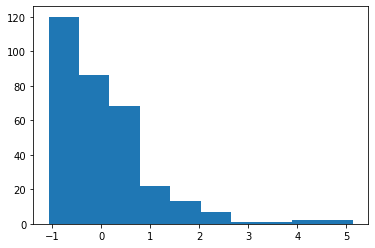

In [151]:
plt.hist(pop_df['z_score'])

#### 2. Dwelling Density

Dwelling and business density measures are to be summed before computing z-score as they will represent a single variable in the risk model

In [153]:
query = '''
SELECT n.area_name, n.area_id, n.dwellings, sa.areasqkm16, n.dwellings/sa.areasqkm16 as dwelling_density
FROM neighbourhoods AS n
INNER JOIN sa2_2016_aust AS sa
ON n.area_id=sa.sa2_main16
ORDER BY n.dwellings/sa.areasqkm16 DESC;
'''

response, dwell_df = pgquery(conn, query)

(322, 5)
                                       area_name    area_id  dwellings  areasqkm16  dwelling_density
0                    Potts Point - Woolloomooloo  117031333     8751.0      1.4591       5997.532726
1                               Pyrmont - Ultimo  117031334     7599.0      1.4913       5095.554214
2                                   Darlinghurst  117031329     3914.0      0.8569       4567.627494
3                                    Surry Hills  117031336     5040.0      1.3164       3828.623519
4                        Waterloo - Beaconsfield  117031338    12544.0      3.5809       3503.029965
5                          Redfern - Chippendale  117031335     7230.0      2.1631       3342.425223
6                       Neutral Bay - Kirribilli  121041416     7298.0      2.2106       3301.366145
7                               Randwick - North  118021569     5623.0      1.9356       2905.042364
8                      Bondi Beach - North Bondi  118011340     6486.0      2.4605

In [154]:
print(len(dwell_df[dwell_df.isna().any(axis=1)]))
dwell_df.head()

0


,area_name,area_id,dwellings,areasqkm16,dwelling_density
0,Potts Point - Woolloomooloo,117031333,8751.0,1.4591,5997.532726
1,Pyrmont - Ultimo,117031334,7599.0,1.4913,5095.554214
2,Darlinghurst,117031329,3914.0,0.8569,4567.627494
3,Surry Hills,117031336,5040.0,1.3164,3828.623519
4,Waterloo - Beaconsfield,117031338,12544.0,3.5809,3503.029965


#### 3. Business Density

In [155]:
query='''
SELECT n.area_name, n.area_id, sa.areasqkm16, busi.number_of_businesses, 
busi.number_of_businesses/sa.areasqkm16 as business_density
FROM neighbourhoods AS n
INNER JOIN sa2_2016_aust AS sa
ON n.area_id=sa.sa2_main16
INNER JOIN businessstats AS busi
ON n.area_id=busi.area_id
ORDER BY busi.number_of_businesses/sa.areasqkm16 DESC;
'''
response, bus_df = pgquery(conn, query)

(322, 5)
                                       area_name    area_id  areasqkm16  number_of_businesses  business_density
0                 Sydney - Haymarket - The Rocks  117031337      4.2934               42126.0       9811.804165
1                    North Sydney - Lavender Bay  121041417      1.9144                7124.0       3721.270372
2                                    Surry Hills  117031336      1.3164                4433.0       3367.517472
3                               Pyrmont - Ultimo  117031334      1.4913                4158.0       2788.171394
4                                   Darlinghurst  117031329      0.8569                2281.0       2661.920878
5                    Potts Point - Woolloomooloo  117031333      1.4591                2875.0       1970.392708
6                       Bondi Junction - Waverly  118011341      2.5234                3846.0       1524.134105
7                       Neutral Bay - Kirribilli  121041416      2.2106                2910.0  

In [156]:
print(len(bus_df[bus_df.isna().any(axis=1)]))
bus_df.head()

0


,area_name,area_id,areasqkm16,number_of_businesses,business_density
0,Sydney - Haymarket - The Rocks,117031337,4.2934,42126.0,9811.804165
1,North Sydney - Lavender Bay,121041417,1.9144,7124.0,3721.270372
2,Surry Hills,117031336,1.3164,4433.0,3367.517472
3,Pyrmont - Ultimo,117031334,1.4913,4158.0,2788.171394
4,Darlinghurst,117031329,0.8569,2281.0,2661.920878


#### Combining measures 2 and 3 for single z-score (final model: five variables)

In [163]:
bus_df_m = bus_df.drop(columns=['area_name','areasqkm16','number_of_businesses'])
dwellbusi_df = pd.merge(dwell_df,bus_df_m, left_on='area_id', right_on='area_id', how='inner')
dwellbusi_df = dwellbusi_df.drop(columns=['dwellings','areasqkm16'])
dwellbusi_df['dwell_and_bus_density'] = dwellbusi_df['dwelling_density'] + dwellbusi_df['business_density']
dwellbusi_df = dwellbusi_df.drop(columns=['dwelling_density','business_density'])
dwellbusi_df = add_z_score_column(dwellbusi_df)
dwellbusi_df

,area_name,area_id,dwell_and_bus_density,z_score
0,Potts Point - Woolloomooloo,117031333,7967.925433,5.213205
1,Pyrmont - Ultimo,117031334,7883.725609,5.149184
2,Darlinghurst,117031329,7229.548372,4.651782
3,Surry Hills,117031336,7196.140991,4.626380
4,Waterloo - Beaconsfield,117031338,4635.147589,2.679134
...,...,...,...,...
317,Port Botany Industrial,117011324,48.138639,-0.808588
318,Rookwood Cemetery,125011475,3.980100,-0.842164
319,Wetherill Park Industrial,127021521,204.169881,-0.689950
320,Smithfield Industrial,125031486,167.608155,-0.717750


#### 4. BFPL Density

For this step a spatial join is performed in the database and then further computations are performed in pandas.

Step 1: Query that produces an output table showing matching shapefile contained membership for every point, filtered for neighbourhood SA2s.

In [ ]:
# WARNINGS PRODUCED WILL PREVENT PRINT OF SQL RESULT IN THE NOTEBOOK, HOWEVER DF WILL BE CREATED

query="""
SELECT * FROM
(
SELECT bf.gid, bf.category, bf.shape_leng, bf.shape_area, sa.sa2_main16, sa.sa2_name16
FROM rfsnsw_bfpl AS bf
    INNER JOIN sa2_2016_aust AS sa ON ST_Contains(sa.geom, bf.geom)
) AS nsw_all_bf
WHERE nsw_all_bf.sa2_main16 IN
(
SELECT sa.sa2_main16
FROM neighbourhoods AS n
    INNER JOIN sa2_2016_aust AS sa
    ON n.area_id=sa.sa2_main16 
)
"""

response, bfpl_step1_df = pgquery(conn, query)

Step 2: 
- Computing weightings for area based on vegetation category 
- and then aggregating area using pandas groupby

In [ ]:
# Function for weighting different vegetation categories
# Based on interpretation of language regarding relative risk levels and difference in required buffer distances 
# outlined in RFS Guideline for Councils to Bushfire Prone Area Land Mapping p. 11
# Note the category number coding does not represent risk ranking (while 1 is highest, 3 is medium, 2 is least)
# Inline function for this task based on post here: 
# https://stackoverflow.com/questions/41962022/apply-function-to-dataframe-column-element-based-on-value-in-other-column-for-sa

def category_weighter(number,condition):
    multiplier = {'1': 3, '2': 1, '3': 1.5}
    return number * multiplier[condition]

bfpl_step1_df['weighted_bfp_area'] = bfpl_step1_df.apply(lambda x: category_weighter(x['shape_area'],
                                                                                     x['category']), axis=1)

bfpl_step2_df = bfpl_step1_df.groupby(['sa2_main16', 'sa2_name16']).agg('weighted_bfp_area').sum().reset_index()
bfpl_step2_df.sort_values(by='weighted_bfp_area',ascending=False)

Step 3: 
- Using a join in pandas to reintroduce the neighbourhoods that contain 0 BFPL
- Computing final density (weighted_bfp_area total/areasqkm16), filling NaNs with 0s
- and computing z-scores.

In [ ]:
bfpl_step3_df = pop_df.copy()
bfpl_step3_df = bfpl_step3_df.drop(columns=['population','population_density','z_score'])
bfpl_step3_df = pd.merge(bfpl_step3_df, bfpl_step2_df, left_on='area_id', right_on='sa2_main16', how='left')
bfpl_step3_df = bfpl_step3_df.drop(columns=['sa2_main16','sa2_name16'])
bfpl_step3_df['bfpl_density'] = bfpl_step3_df['weighted_bfp_area']/bfpl_step3_df['areasqkm16']

bfpl_step3_df['weighted_bfp_area'] = bfpl_step3_df['weighted_bfp_area'].fillna(0)
bfpl_step3_df['bfpl_density'] = bfpl_step3_df['bfpl_density'].fillna(0)

bfpl_density = add_z_score_column(bfpl_step3_df)

bfpl_density.sort_values(by='z_score',ascending=False)

#### 5. Assistive Service Density

In [ ]:
query='''
SELECT n.area_name, n.area_id, sa.areasqkm16, busi.health_care_and_social_assistance,
busi.health_care_and_social_assistance/sa.areasqkm16 as assistive_service_density
FROM neighbourhoods AS n
INNER JOIN sa2_2016_aust AS sa
ON n.area_id=sa.sa2_main16
INNER JOIN businessstats AS busi
ON n.area_id=busi.area_id
ORDER BY busi.health_care_and_social_assistance/sa.areasqkm16 DESC;
'''

response, ass_serv_df = pgquery(conn, query)
ass_serv_df = add_z_score_column(ass_serv_df)

In [ ]:
print(len(ass_serv_df[ass_serv_df.isna().any(axis=1)]))
ass_serv_df.head()

#### 6. Exchange Density

In [ ]:
# We assume truth of Geoscience Australia communications exchanges dataset 
# i.e. NAN results from spatial subquery join == 0 exchanges in area and therefore 0 density
# CASE clause handles the columns which we ultimately pass to our df (so no NaNs dealt with at notebook end)

query='''
SELECT n.area_name, n.area_id, nsw_result.count AS exchanges_nans, sa.areasqkm16,
nsw_result.count/sa.areasqkm16 AS exchange_density_nans,
CASE
WHEN nsw_result.count IS NULL THEN 0
    ELSE nsw_result.count
END AS exchanges,
CASE
    WHEN nsw_result.count/sa.areasqkm16 IS NULL THEN 0
    ELSE nsw_result.count/sa.areasqkm16
END AS exchange_density
FROM neighbourhoods AS n
    INNER JOIN sa2_2016_aust AS sa
    ON n.area_id=sa.sa2_main16 
    LEFT JOIN
        (
            SELECT sa.sa2_main16, sa.sa2_name16, COUNT(e.geom)
            FROM sa2_2016_aust AS sa
                INNER JOIN exchanges AS e ON ST_Contains(sa.geom, e.geom)
            GROUP BY sa.sa2_main16, sa.sa2_name16
        ) AS nsw_result
ON n.area_id = nsw_result.sa2_main16
ORDER BY nsw_result.count/sa.areasqkm16;

'''

response, exchange_df = pgquery(conn, query)
exchange_df = exchange_df.drop(columns=['exchanges_nans','exchange_density_nans'])
exchange_df = add_z_score_column(exchange_df)

In [ ]:
exchange_df.tail()

#### Observing the distribution of the z-scores

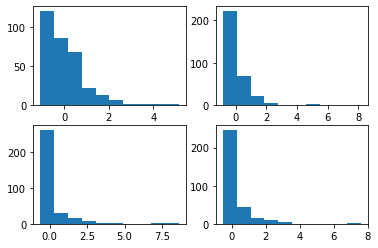

In [166]:
fig, axes = plt.subplots(2,2)
computed_measures = [pop_df, dwellbusi_df, ass_serv_df, exchange_df]

for type, ax in zip(computed_measures, axes.flatten()):
    ax.hist(type['z_score'])

### Fire Risk Score

Provided model:

$$fire_risk = S(z(population_density)+z(dwelling_&_business_density)+z(bfpl_density)−z(assistive_service_density))$$

Refined model:

$$fire_risk = S(0.1*z(population_density)+0.1*z(dwelling_&_business_density)+3*z(bfpl_density)−0.5*z(assistive_service_density-0.5*z(exchange_density))$$

While significantly reweighting the model towards bushfire prone land density, we justify these weightings because the other variables, even with decreased weighting, still contribute to construct relative risk based on areas that are:
- populated
- under-serviced
- contain bushfire prone land
- contain relatively greater amounts of the higher risk vegetation categories (based on weightings done in preprocessing work)

Without refinement, the model is too sensitive to populated urban areas which have zero BFPL and should not receive high risk scores. 

#### Creation of dataframe with all measures
First step for creation of computed risk score table. A series of pandas joins integrates the computed measures into a single dataframe while ensuring correct matching with area_id.

In [198]:
fire_risk_df = pop_df.copy()
fire_risk_df = fire_risk_df.drop(columns=['population','areasqkm16'])
fire_risk_df = fire_risk_df.rename(columns={"z_score": "pop_z_score"})

fire_risk_df = pd.merge(fire_risk_df, dwellbusi_df, left_on='area_id', right_on='area_id', how='inner')
fire_risk_df = fire_risk_df.drop(columns=['area_name_y'])
fire_risk_df = fire_risk_df.rename(columns={"z_score": "dwell_and_bus_z_score"})

fire_risk_df = pd.merge(fire_risk_df, bfpl_density, left_on='area_id', right_on='area_id', how='inner')
fire_risk_df = fire_risk_df.drop(columns=['area_name','areasqkm16','weighted_bfp_area'])
fire_risk_df = fire_risk_df.rename(columns={"z_score": "bf_z_score"})

fire_risk_df = pd.merge(fire_risk_df, ass_serv_df, left_on='area_id', right_on='area_id', how='inner')
fire_risk_df = fire_risk_df.drop(columns=['area_name','areasqkm16','health_care_and_social_assistance'])
fire_risk_df = fire_risk_df.rename(columns={"z_score": "asst_z_score"})

fire_risk_df = pd.merge(fire_risk_df, exchange_df, left_on='area_id', right_on='area_id', how='inner')
fire_risk_df = fire_risk_df.drop(columns=['area_name','areasqkm16','exchanges'])
fire_risk_df = fire_risk_df.rename(columns={"z_score": "exch_z_score"})

fire_risk_df = fire_risk_df.rename(columns={'area_name_x': 'area_name'})

fire_risk_df

,area_name,area_id,population_density,pop_z_score,dwell_and_bus_density,dwell_and_bus_z_score,bfpl_density,bf_z_score,assistive_service_density,asst_z_score,exchange_density,exch_z_score
0,Holsworthy Military Area,123021439,0.000000,-1.080651,0.000000,-0.845190,0.000481,4.319758,0.000000,-0.616531,0.000000,-0.535349
1,Potts Point - Woolloomooloo,117031333,16317.593037,5.131561,7967.925433,5.213205,0.000000,-0.401696,108.285930,2.436696,0.000000,-0.535349
2,Pyrmont - Ultimo,117031334,16148.997519,5.067376,7883.725609,5.149184,0.000000,-0.401696,111.982834,2.540934,0.000000,-0.535349
3,Darlinghurst,117031329,14487.104680,4.434682,7229.548372,4.651782,0.000000,-0.401696,326.759248,8.596765,1.166997,7.619263
4,Surry Hills,117031336,13722.272865,4.143506,7196.140991,4.626380,0.000000,-0.401696,156.487390,3.795783,0.000000,-0.535349
...,...,...,...,...,...,...,...,...,...,...,...,...
317,Singleton Region,106011113,1.209421,-1.080190,0.676873,-0.844676,0.000135,0.919926,0.002459,-0.616462,0.000246,-0.533631
318,Rookwood Cemetery,125011475,0.995025,-1.080272,3.980100,-0.842164,0.000000,-0.401696,0.000000,-0.616531,0.000000,-0.535349
319,Royal National Park,128021537,0.200957,-1.080574,0.050239,-0.845152,0.000287,2.417712,0.000000,-0.616531,0.000000,-0.535349
320,Blue Mountains - North,124011451,0.021847,-1.080642,0.015125,-0.845179,0.000103,0.607833,0.000000,-0.616531,0.001681,-0.523606


#### Calculation of fire risk scores

In [199]:
# Nominated coefficients to address confounding variable of population and the relative importance of BFPL
# 0.1(population_density)
# 0.1(dwelling_&_business_density)
# 3(bfpl_density)
# 0.5(assistive_service_density)
# 0.5(exchange_density)

fire_risk_df['untransformed'] = 0.1*(fire_risk_df['pop_z_score']) + 0.1*(fire_risk_df['dwell_and_bus_z_score']) + 3*(fire_risk_df['bf_z_score']) - 0.5*(fire_risk_df['asst_z_score']) - 0.5*(fire_risk_df['exch_z_score'])
fire_risk_df['fire_risk_score'] = fire_risk_df['untransformed'].apply(lambda x: sigmoid(x))
fire_risk_df.sort_values(by='fire_risk_score',ascending=False)


,area_name,area_id,population_density,pop_z_score,dwell_and_bus_density,dwell_and_bus_z_score,bfpl_density,bf_z_score,assistive_service_density,asst_z_score,exchange_density,exch_z_score,untransformed,fire_risk_score
225,Woronora Heights,128021609,1173.264487,-0.633981,419.136865,-0.526501,0.001060,9.995572,3.506088,-0.517674,0.000000,-0.535349,30.397179,1.000000
240,Narara,102011035,889.757339,-0.741914,296.932006,-0.619419,0.000894,8.369914,1.687851,-0.568941,0.000000,-0.535349,25.525754,1.000000
0,Holsworthy Military Area,123021439,0.000000,-1.080651,0.000000,-0.845190,0.000481,4.319758,0.000000,-0.616531,0.000000,-0.535349,13.342631,0.999998
277,Bayview - Elanora Heights,122021421,175.851230,-1.013703,73.688122,-0.789162,0.000441,3.921534,0.603874,-0.599505,0.000000,-0.535349,12.151741,0.999995
253,Chittaway Bay - Tumbi Umbi,102021047,640.730491,-0.836720,244.667042,-0.659158,0.000367,3.195117,2.000114,-0.560136,0.040819,-0.250121,9.840891,0.999947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,Kogarah,119041378,5507.951525,1.016262,2344.460963,0.937416,0.000000,-0.401696,118.484480,2.724254,0.450511,2.612683,-3.678188,0.024646
32,North Sydney - Lavender Bay,121041417,6173.735896,1.269730,5851.964062,3.604338,0.000000,-0.401696,136.335144,3.227571,0.522357,3.114717,-3.888824,0.020059
16,Bondi Junction - Waverly,118011341,7257.668225,1.682390,3259.491163,1.633157,0.000000,-0.401696,184.671475,4.590461,0.396291,2.233806,-4.285666,0.013578
18,Sydney - Haymarket - The Rocks,117031337,7222.713933,1.669083,11899.427028,8.202514,0.000000,-0.401696,283.458331,7.375853,1.164578,7.602359,-7.707033,0.000449


### Integration of the computed measures and risk scores into the database

In [200]:
# Reduce the dataframe to: measures and risk score and normalised design (no 'area_name')
fire_risk_df = fire_risk_df.drop(columns=['area_name','pop_z_score','dwell_and_bus_z_score','bf_z_score','asst_z_score','exch_z_score','untransformed'])

# Table creation query
conn.execute("DROP TABLE IF EXISTS fire_risk")

score_create = '''CREATE TABLE fire_risk (
                     area_id VARCHAR NOT NULL,
                     population_density FLOAT NOT NULL,
                     dwell_and_bus_density FLOAT NOT NULL,
                     bfpl_density FLOAT NOT NULL,
                     assistive_service_density FLOAT NOT NULL,
                     exchange_density FLOAT NOT NULL,
                     fire_risk_score FLOAT NOT NULL,
                     CONSTRAINT fire_risk_pkey PRIMARY KEY (area_id),
                     CONSTRAINT fire_risk_fkey1 FOREIGN KEY(area_id) REFERENCES statisticalareas(area_id)
                     )'''

conn.execute(score_create)

In [201]:
fire_risk_df.to_sql('fire_risk', con = conn, if_exists = 'append', index=False)
print('Data inserted into Table')

# Check table
a_response, a_df = pgquery(conn, """SELECT * FROM fire_risk
LIMIT 1;""")

Data inserted into Table
(1, 7)
     area_id  population_density  dwell_and_bus_density  bfpl_density  assistive_service_density  exchange_density  fire_risk_score
0  123021439                 0.0                    0.0      0.000481                        0.0               0.0         0.999998


### Linear Regression & Correlation

Pearson correlation coefficient calculated.
<div>
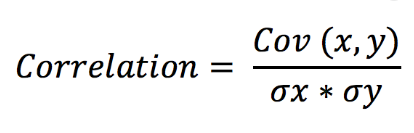
</div>

In [204]:
query='''SELECT nb.area_name, nb.median_income, nb.avg_monthly_rent, fr.fire_risk_score 
            FROM fire_risk AS fr
                INNER JOIN neighbourhoods AS nb
                ON (nb.area_id=fr.area_id);'''

response, example_df = pgquery(conn, query)
example_df.head()

(322, 4)
                                       area_name  median_income  avg_monthly_rent  fire_risk_score
0                       Avoca Beach - Copacabana        46996.0            1906.0         0.443903
1                    Box Head - MacMasters Beach        42621.0            1682.0         0.989128
2                                Calga - Kulnura        42105.0            1182.0         0.621319
3                            Erina - Green Point        43481.0            1595.0         0.457740
4                          Gosford - Springfield        45972.0            1382.0         0.344117
5                                        Kariong        47896.0            1649.0         0.258389
6                    Kincumber - Picketts Valley        41642.0            1397.0         0.434413
7                                         Narara        46660.0            1512.0         1.000000
8                         Niagara Park - Lisarow        45762.0            1495.0         0.488230
9

,area_name,median_income,avg_monthly_rent,fire_risk_score
0,Avoca Beach - Copacabana,46996.0,1906.0,0.443903
1,Box Head - MacMasters Beach,42621.0,1682.0,0.989128
2,Calga - Kulnura,42105.0,1182.0,0.621319
3,Erina - Green Point,43481.0,1595.0,0.457740
4,Gosford - Springfield,45972.0,1382.0,0.344117


In [ ]:
from sklearn.linear_model import LinearRegression

def LinearReg(y, X):
    query = """SELECT area_id, fire_risk_score, {X} FROM neighbourhoods INNER JOIN fire_risk USING(area_id);""".format(x=x)
    response, df = pgquery(conn, query)
    y = df.loc[:, fire_risk_score]
    X = df.loc[:, X]
    reg = LinearRegression().fit(X,y)
    cor = df[['fire_risk_score', X]].corr()
    return reg, cor
    

In [ ]:

reg_model, cor = LinearReg('fire_risk_score', 'median_income')


In [205]:
# ------------------------------------
#         DISCONNECT FROM DB!
# ------------------------------------

conn.close()
db.dispose()
print("disconnected")

disconnected
